In [3]:
import torch
import torchvision.datasets as datasets

%load_ext autoreload
%autoreload 2

In [4]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

train_dataset = mnist_trainset.data[:-10000].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1, 1, 28, 28) / 255.

In [7]:
from pythae.models import Adversarial_AE, Adversarial_AE_Config
from pythae.trainers import AdversarialTrainer, AdversarialTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_VAE_MNIST, Decoder_AE_MNIST


In [9]:
config = AdversarialTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=10,
)


model_config = Adversarial_AE_Config(
    input_dim=(1, 28, 28),
    latent_dim=16,
    adversarial_loss_scale=0.9
)

model = Adversarial_AE(
    model_config=model_config,
    encoder=Encoder_VAE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)

In [10]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [11]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Adversarial Trainer

Model passed sanity check !

Created my_model/Adversarial_AE_training_2022-03-23_12-11-09. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91batch/s]
--------------------------------------------------------------------------
Train loss: 6.7235
Eval loss: 2.6519
--------------------------------------------------------------------------
Eval of epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:52<00:00,  1.91batch/s]
------------------------

In [12]:
import os

In [13]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = Adversarial_AE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))
#my_model/Adversarial_AE_training_2022-03-23_12-07-21/final_model

In [14]:
from pythae.samplers import NormalSampler

In [15]:
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)

In [16]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

In [17]:
import matplotlib.pyplot as plt

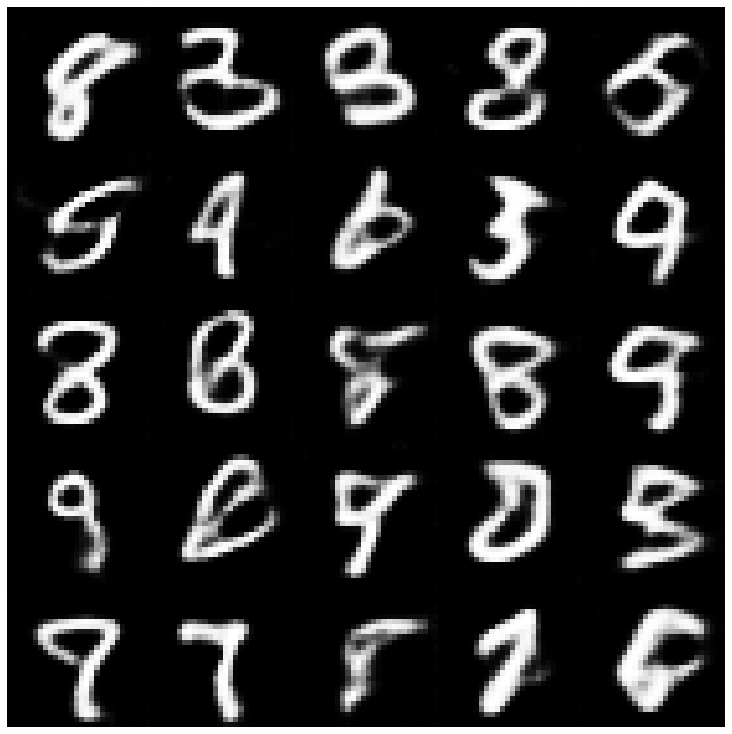

In [18]:
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [19]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

In [20]:
# set up gmm sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)

In [23]:
# sample
gen_data = gmm_sampler.sample(
    num_samples=100
)

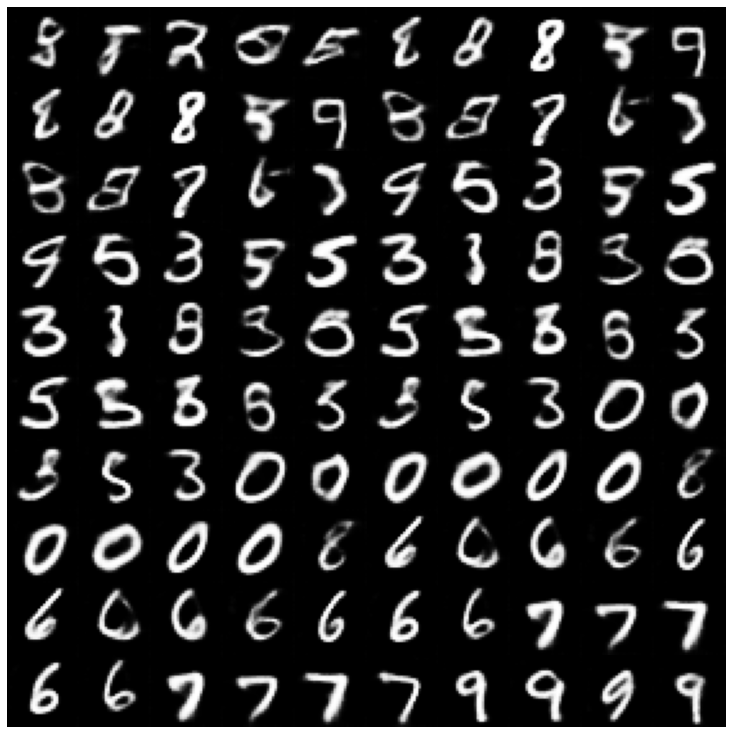

In [26]:
# show results with gmm sampler
fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))

for i in range(10):
    for j in range(10):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [32]:
gmm_sampler.gmm.means_.shape

(10, 16)

In [42]:
means = torch.tensor(gmm_sampler.gmm.means_).float()
trained_model.cpu()
recon = trained_model.decoder(means)

In [44]:
recon[0].shape

torch.Size([10, 1, 28, 28])

In [47]:
from torchvision.utils import make_grid
def plot_images(imgs, nrow=16, transform=torch.nn.Identity(), out=plt):
    imgs = transform(imgs)
    grid_imgs = make_grid(imgs, nrow=nrow).permute(1, 2, 0)
    #plt.imshow(grid_imgs)
    out.imshow(grid_imgs)


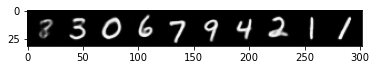

In [48]:
plot_images(recon[0])

In [49]:
gmm_sampler.model

Adversarial_AE(
  (decoder): Decoder_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=16384, bias=True)
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_VAE_MNIST(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps

In [50]:
trained_model


Adversarial_AE(
  (decoder): Decoder_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=16384, bias=True)
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_VAE_MNIST(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps

In [51]:
path = "my_model/Adversarial_AE_training_2022-03-23_12-07-21/final_model"
#trained_model = Adversarial_AE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))
trained_model = Adversarial_AE.load_from_folder(path)

In [52]:
# set up gmm sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)


In [53]:
means = torch.tensor(gmm_sampler.gmm.means_).float()
trained_model.cpu()
recon = trained_model.decoder(means)

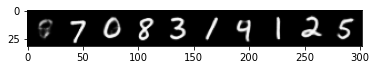

In [54]:
plot_images(recon[0])


now test the VAE model

In [57]:
from pythae.models import VAE, VAEConfig
from pythae.trainers import BaseTrainerConfig
from pythae.pipelines.training import TrainingPipeline
from pythae.models.nn.benchmarks.mnist import Encoder_VAE_MNIST, Decoder_AE_MNIST
config = BaseTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=15,
)


model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=16
)

model = VAE(
    model_config=model_config,
    encoder=Encoder_VAE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)

In [58]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model
)

In [59]:
pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created my_model/VAE_training_2022-03-23_13-00-24. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.41batch/s]
--------------------------------------------------------------------------
Train loss: 47.8132
Eval loss: 33.1881
--------------------------------------------------------------------------
Eval of epoch 2/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:22<00:00,  4.41batch/s]
----------------------------------------

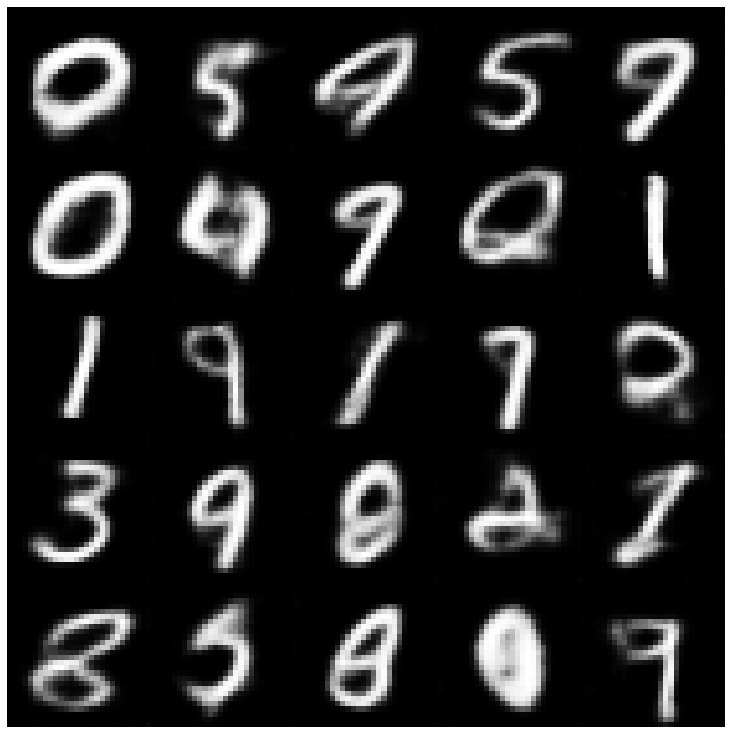

In [60]:
last_training = sorted(os.listdir('my_model'))[-1]
trained_model = VAE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)
# sample
gen_data = normal_samper.sample(
    num_samples=25
)
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

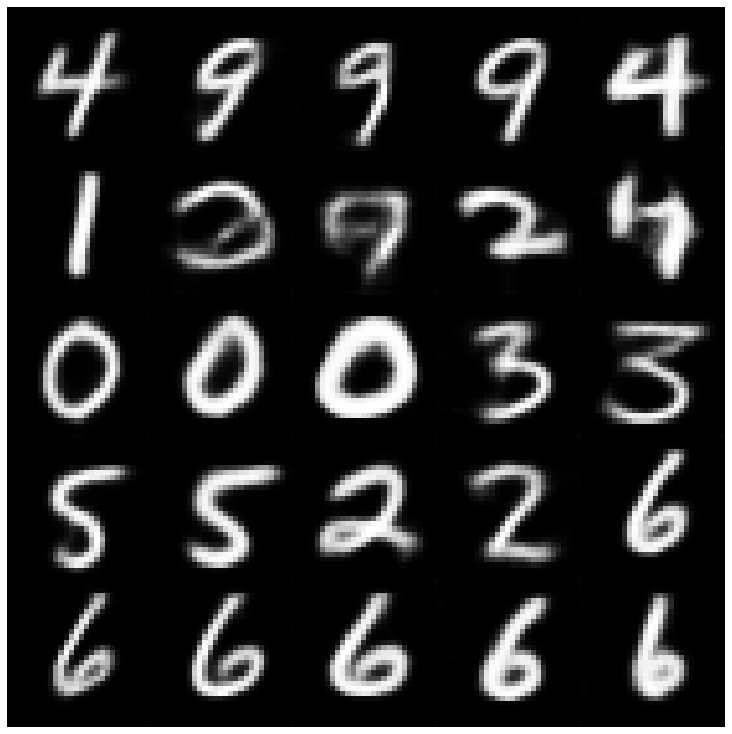

In [61]:
# set up GMM sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)
# sample
gen_data = gmm_sampler.sample(
    num_samples=25
)
# show results with gmm sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

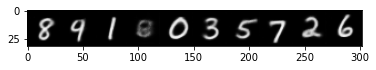

In [62]:
means = torch.tensor(gmm_sampler.gmm.means_).float()
trained_model.cpu()
recon = trained_model.decoder(means)
plot_images(recon[0])


In [63]:
model

VAE(
  (decoder): Decoder_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=16384, bias=True)
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_VAE_MNIST(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, mom

In [68]:
x = torch.rand(10,1,28,28)
model.cpu()
x.shape
model.encoder(x)['embedding'].shape

torch.Size([10, 16])

In [77]:
from torch import nn
model2 = VAE(
    model_config=model_config,
    encoder=Encoder_VAE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)
model2.encoder.layers

ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

In [79]:
model2.encoder.layers = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28**2, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(), )
#model2.encoder(x).shape
model2.encoder(x)['embedding'].shape

torch.Size([10, 16])

In [80]:
model2.decoder.layers

ModuleList(
  (0): Linear(in_features=16, out_features=16384, bias=True)
  (1): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): Sequential(
    (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): Sigmoid()
  )
)

In [84]:
z = torch.randn(10,16)
model2.decoder(z)['reconstruction'].shape

torch.Size([10, 1, 28, 28])

In [96]:
model2.decoder.layers[1] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(16384, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
)
model2.decoder.layers[2] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
)
model2.decoder.layers[3] = nn.Sequential(
    nn.Flatten(),
    nn.Linear(1024,1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024,28**2),
    nn.Sigmoid(),
    nn.Unflatten(dim=-1, unflattened_size=(-1,28,28)),
)
    

In [97]:
model2.cpu()
model2.decoder(z)['reconstruction'].shape


torch.Size([10, 1, 28, 28])

In [106]:
pipeline = TrainingPipeline(
    training_config=config,
    model=model2
)

pipeline(
    train_data=train_dataset,
    eval_data=eval_dataset
)

Preprocessing train data...
Preprocessing eval data...

Using Base Trainer

Model passed sanity check !

Created my_model/VAE_training_2022-03-23_14-00-53. 
Training config, checkpoints and final model will be saved here.

Successfully launched training !

Eval of epoch 1/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.07batch/s]
--------------------------------------------------------------------------
Train loss: 37.1668
Eval loss: 32.1409
--------------------------------------------------------------------------
Eval of epoch 2/15: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 18.31batch/s]
----------------------------------------

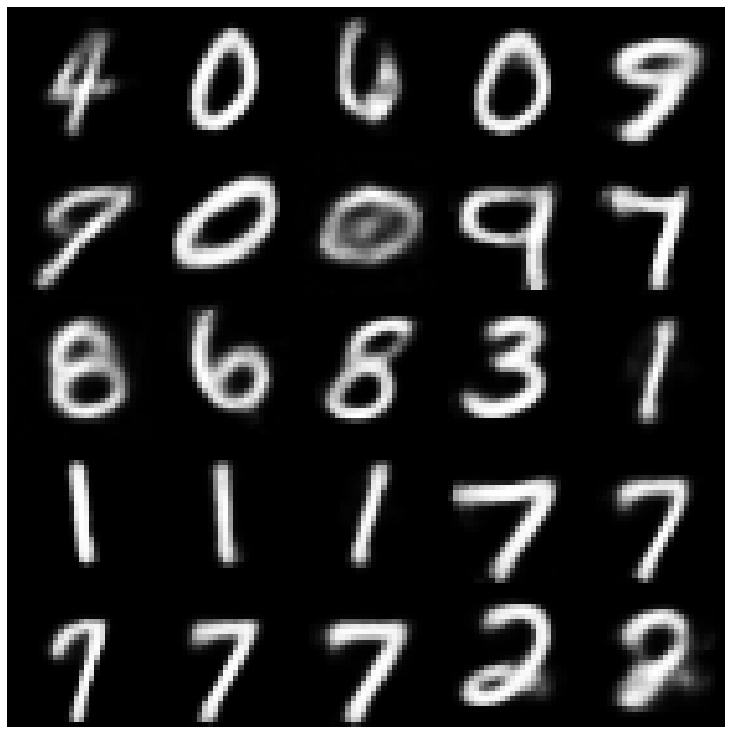

In [107]:
# set up GMM sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=model2
)

# fit the sampler
gmm_sampler.fit(train_dataset)
# sample
gen_data = gmm_sampler.sample(
    num_samples=25
)
# show results with gmm sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)


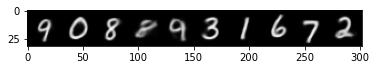

In [108]:
means = torch.tensor(gmm_sampler.gmm.means_).float()
model2.cpu()
recon = model2.decoder(means)
plot_images(recon[0])


In [109]:
z.shape

torch.Size([10, 16])

In [110]:
x.shape

torch.Size([10, 1, 28, 28])

In [113]:
config = AdversarialTrainerConfig(
    output_dir='my_model',
    learning_rate=1e-3,
    batch_size=100,
    num_epochs=10,
)


model_config = Adversarial_AE_Config(
    input_dim=(1, 28, 28),
    latent_dim=16,
    adversarial_loss_scale=0.9
)

model3 = Adversarial_AE(
    model_config=model_config,
    encoder=Encoder_VAE_MNIST(model_config), 
    decoder=Decoder_AE_MNIST(model_config) 
)

In [114]:
model3

Adversarial_AE(
  (decoder): Decoder_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=16384, bias=True)
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_VAE_MNIST(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps

In [118]:
path = "my_model/Adversarial_AE_training_2022-03-23_12-07-21/final_model"
#trained_model = Adversarial_AE.load_from_folder(os.path.join('my_model', last_training, 'final_model'))
model3 = Adversarial_AE.load_from_folder(path)
model3.discriminator(z)


ModelOutput([('embedding',
              tensor([[0.7403],
                      [0.5390],
                      [0.4877],
                      [0.5551],
                      [0.5902],
                      [0.6830],
                      [0.5105],
                      [0.5133],
                      [0.6849],
                      [0.6133]], grad_fn=<SigmoidBackward0>))])

In [123]:
x = train_dataset[0:3]
output = model3.encoder(x)
model3.discriminator(output['embedding'])

ModelOutput([('embedding',
              tensor([[0.6118],
                      [0.5921],
                      [0.5474]], grad_fn=<SigmoidBackward0>))])

In [124]:
model3

Adversarial_AE(
  (decoder): Decoder_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=16, out_features=16384, bias=True)
      (1): Sequential(
        (0): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(256, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): Sigmoid()
      )
    )
  )
  (encoder): Encoder_VAE_MNIST(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps

In [125]:
model3.adversarial_loss_scale

0.9